# Implementación de una LSTM

Las Long-Short Term Memories o LSTM son una herramienta de gran utilidad cuando se trabaja con RNNs, pues evitan el desvanecimiento del gradiente y conservan adecuadamente las dependencias a largo plazo. Realizaremos un ejemplo muy simple de una LSTM, aplicadno el algoritmo de backpropagation y de gradien descent.

In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
from collections import defaultdict, Counter
from preprocessing import preprocess
from itertools import chain
import seaborn as sns


#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc.split()]

Al igual que con modelos del lenguaje más tradicionales, tomamos un corpus e indexamos las palabras con valores numéricos, con el objetivo de que sea más fácil manejarlas.

In [2]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'el perro come', 'el gato come croquetas', 'un gato come']

#Llamamos la funcion para crear el vocabulario
voc = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
sentences = list(text2numba(corpus,voc))

print(sentences)

[[0, 1, 2, 3, 4], [3, 5, 6], [0, 5, 7, 8, 9], [3, 1, 2, 10], [0, 1, 2], [0, 11, 2, 10], [3, 11, 2]]


Además, tenemos que añadir los símbolos de BOS (Beginning Of Sentence) y EOS (End Of Sentence). Estas palabras también se añaden al vocabulario con índices numéricos.

In [3]:
#Indicamos las etiquetas a usar
EOS = '<EOS>'
BOS = '<BOS>'

#Cada etiqeuta se le asigna un indice numerico
BOS_IDX = max(voc.values())+2
EOS_IDX = max(voc.values())+1

#Se agregan estas etiqeutas al vocabulario
voc[EOS] = EOS_IDX
voc[BOS] = BOS_IDX

#A cada cadena se le agrega la etiqueta BOS al inicio y EOS al final
cadenas = [[BOS_IDX] + cad + [EOS_IDX] for cad in sentences]

#Se obtiene la longitud del alfabeto
N = len(voc)

print(voc)

defaultdict(<function vocab.<locals>.<lambda> at 0x00000241CF7D6400>, {'el': 0, 'perro': 1, 'come': 2, 'un': 3, 'hueso': 4, 'muchacho': 5, 'jugaba': 6, 'saltaba': 7, 'la': 8, 'cuerda': 9, 'croquetas': 10, 'gato': 11, '<EOS>': 12, '<BOS>': 13})


Entonces generamos los ejemplos, estos son pares de tuplas dadas como:

$$(BOS w_1 ...w_T; w_1 ... w_T EOS)$$

Lo que buscamos, es predecir la palabra subsiguiente, como en un modelo del lenguaje. Así dada la palabra $w_1$, querermos que se prediga la palabra subsiguiente $w_2$. Por tanto, los ejemplos de entrenamiento toman como entrada la cadena (sin EOS) y buscan emitir la cadena adelantada un estado. 

In [4]:
examples = [(s[:-1],s[1:]) for s in cadenas]
print(examples)

[([13, 0, 1, 2, 3, 4], [0, 1, 2, 3, 4, 12]), ([13, 3, 5, 6], [3, 5, 6, 12]), ([13, 0, 5, 7, 8, 9], [0, 5, 7, 8, 9, 12]), ([13, 3, 1, 2, 10], [3, 1, 2, 10, 12]), ([13, 0, 1, 2], [0, 1, 2, 12]), ([13, 0, 11, 2, 10], [0, 11, 2, 10, 12]), ([13, 3, 11, 2], [3, 11, 2, 12])]


### Entrenamiento de la red

Recordemos que una LSTM se define a partir de 3 puertas $i$, $o$ y $f$ (escritura, lectura y olvido), dadas por las siguientes funciones:

$$i_t = \sigma(U^ix^{(t)} + V^ih^{(t-1)} + b^i)$$

$$o_t = \sigma(U^ox^{(t)} + V^oh^{(t-1)} + b^o)$$

$$f_t = \sigma(U^fx^{(t)} + V^fh^{(t-1)} + b^f)$$

Asimismo, se define el candidato a sombra de la forma:

$$\hat{c}_t = \tanh(U^cx^{(t)} + V^ch^{(t-1)} + b^c)$$

La sombra (la información que se mandará al siguiente estado) se define, entonces como:

$$c_t = f_t \odot c_{t-1} + i_t \odot \hat{c}_t$$

Y finalmente, la celda de salida para ese estado está dado por:

$$h_t = o_t \odot \tanh(c_t)$$

Ya que las puertas en el LSTM utilizan la función sigmoide, definimos ésta a continuación:

In [5]:
def sig(x):
    return 1./(1.+np.exp(-x))

Ahora inicializamos los parámetros $\theta$. Estos parámetros son los siguientes:

1) Parámetros de la puerta de escritura: $V^i\in\mathbb{R}^{m\times m}$, $U^i\in\mathbb{R}^{m\times N}$ y $b^i\in\mathbb{R}^m$.

2) Parámetros de la puerta de olvido: $V^f\in\mathbb{R}^{m\times m}$, $U^f\in\mathbb{R}^{m\times N}$ y $b^f\in\mathbb{R}^m$.

3) Parámetros de la puerta de lectura: $V^o\in\mathbb{R}^{m\times m}$, $U^o\in\mathbb{R}^{m\times N}$ y $b^o\in\mathbb{R}^m$.

4) Parámetros de la sombra: $V^c\in\mathbb{R}^{m\times m}$, $U^c\in\mathbb{R}^{m\times N}$ y $b^c\in\mathbb{R}^m$.

5) Parámetros de la capa de salida: $W\in\mathbb{R}^{N\times m}$y $b\in\mathbb{R}^N$.

In [6]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = N
#El total de clases que arrojará
output_dim = N

#Embedding
dim = 2

#Dimensiones de los vectores-palabra
cell_dim = 3

#Embedding matrix
C = np.random.randn(dim,N) / np.sqrt(N)

#Celda de escritura
Vi = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Ui = np.random.randn(cell_dim,dim) / np.sqrt(dim)
bi = np.zeros(cell_dim)

#Celda de olvido
Vf = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Uf = np.random.randn(cell_dim,dim) / np.sqrt(dim)
bf = np.zeros(cell_dim)

#Celda de lectura
Vo = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Uo = np.random.randn(cell_dim,dim) / np.sqrt(dim)
bo = np.zeros(cell_dim)

#Celda de candidato
Vc = np.random.randn(cell_dim,cell_dim) / np.sqrt(cell_dim)
Uc = np.random.randn(cell_dim,dim) / np.sqrt(dim)
bc = np.zeros(cell_dim)

#Capa de salida
W = np.random.randn(N,cell_dim) / np.sqrt(cell_dim)
b = np.zeros(N)

Finalmente aplicamos el entrenamiento. En este caso, aplicamos el LSTM, y la capa de salida. Posteriormente aplicamos backpropagation sobre todos los parámetros para poder actualizarlos por medio del gradiente descendiente.

In [7]:
%%time
it = 100
lr = 0.1

for t in range(it):
        
    for (seq,target_seq) in examples:
        #Inicializacion de celdas
        h = np.zeros((len(seq)+1,cell_dim))
        #Inicializacion de sombras
        c = np.zeros((len(seq)+1,cell_dim))
        #Variable de cambio
        d_t = np.zeros(cell_dim)
        
        for t,w in enumerate(seq):
            #Embedding
            x = C.T[w]
            #LSTM
            #Puerta de escritura
            i = sig(np.dot(Vi,h[t]) + np.dot(Ui,x) + bi)
            #Puerta de olvido
            f = sig(np.dot(Vf,h[t]) + np.dot(Uf,x) + bf)
            #Puerta de escritura
            o = sig(np.dot(Vo,h[t]) + np.dot(Uo,x) + bo)
            
            #Candidato a sombra
            c_hat = np.tanh(np.dot(Vc,h[t]) + np.dot(Uc,x) + bc)
            
            #Sombra en el estado actual
            c[t+1] = f*c[t] + i*c_hat
            
            #Celda en el estado actual
            h[t+1] = o*np.tanh(c[t+1])
            
            #FORWARD SALIDA
            #Softmax
            p = np.exp(np.dot(W,h[t+1])+b)
            phi = p/p.sum(0)
            
            #BACK-PROP
            #Variable de salida
            d_out = phi
            d_out[target_seq[t]] -= 1
            #GD salida
            dW = np.outer(d_out,h[t+1])
            W -=lr*dW
            
            #Variable de lectura
            d_o = np.dot(W.T,d_out)*np.tanh(c[t+1])*o*(1-o)
            #GD lectura Vo
            dVo = np.outer(d_o,h[t])
            Vo -= lr*dVo
            #GD lectura Uo
            dUo = np.outer(d_o,x)
            Uo -= lr*dUo
            #GD emb
            do_emb = np.dot(Uo.T,d_o)
            C.T[w] -= lr*do_emb
            
            #Varible de estado (se usa en escritura, olvido y sombra)
            d_st = np.dot(W.T,d_out)*o*(1-np.tanh(c[t+1])**2) + d_t
                        
            #Variable de sombra
            d_c = d_st*i*(1-c_hat**2)
            #GD sombra Vc
            dVc = np.outer(d_c,h[t])
            Vc -= lr*dVc
            #GD sombra Uc
            dUc = np.outer(d_o,x)
            Uc -= lr*dUc
            #GD emb
            dc_emb = np.dot(Uc.T,d_c)
            C.T[w] -= lr*dc_emb
            
            #Variable de escritura
            d_i = d_st*c_hat*i*(1-i)
            #GD escritura Vi
            dVi = np.outer(d_i,h[t])
            Vi -= lr*dVi
            #GD escritura Ui
            dUi = np.outer(d_i,x)
            Ui -= lr*dUi
            #GD emb
            di_emb = np.dot(Ui.T, d_i)
            C.T[w] -= lr*di_emb
            
            #Variable de olvido
            d_f = d_st*c[t+1]*f*(1-f)
            #GD olvido Vf
            dVf = np.outer(d_f,h[t])
            Vf -= lr*dVf
            #GD olvido Uf
            dUf = np.outer(d_f,x)
            Uf -= lr*dUf
            #GD emb
            df_emb = np.dot(Uf.T,d_f)
            C.T[w] -= lr*df_emb           
            
            #Nueva variable de cambio
            d_t = f*d_st

Wall time: 1.72 s


### Cálculo de probabilidades

Una vez aprendidos los pesos, podemos pasar a utilizar la RNN con LSTM para diferentes tares. Así, definimos una función foward. Para el LSTM, tenemos:

$$h^{(t)},c^{(t)} = LSTM(x^{(t)},h^{(t-1)},c^{(t-1)})$$

En la capa de salida, tenemos:

$$\phi(x^{(t)}) = Softmax(Wh^{(t)} + b)$$

Así, la aplicación de backpropagation sobre las LSTMs implica derivar sobre las celdas: en este sentido debemos derivar sobre las puertas, la sombra y el estado. 

In [8]:
def forward(sent, h = np.zeros(cell_dim),c=np.zeros(cell_dim)):
    sent = sent.split()
    prob_tot = np.zeros((len(sent),N))
    
    for t,w in enumerate(sent):
        #Embedding
        x = C.T[voc[w]]
        #LSTM
        #Puerta de escritura
        i = sig(np.dot(Vi,h) + np.dot(Ui,x) + bi)
        #Puerta de olvido
        f = sig(np.dot(Vf,h) + np.dot(Uf,x) + bf)
        #Puerta de escritura
        o = sig(np.dot(Vo,h) + np.dot(Uo,x) + bo)

        #Candidato a sombra
        c_hat = np.tanh(np.dot(Vc,h) + np.dot(Uc,x) + bc)

        #Sombra en el estado actual
        c = f*c + i*c_hat

        #Celda en el estado actual
        h = o*np.tanh(c)

        #FORWARD SALIDA
        #Softmax
        p = np.exp(np.dot(W,h)+b)
        phi = p/p.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = phi
        
    return h,c, prob_tot    

Una aplicación sencilla es el modelo del lenguaje. Así, podemos obtener, por ejemplo las probabilidades iniciales de la manera siguiente:

In [9]:
h,c,probs = forward('<BOS>')
for word in voc.keys():
    print(word, probs[-1][voc[word]])

el 0.2206602901957738
perro 0.0019482656859080658
come 0.05052825839249425
un 0.2116536108434399
hueso 0.0020811816408655938
muchacho 0.001989098397714183
jugaba 0.001301033257781349
saltaba 0.0020422913373089263
la 0.0016427614852434424
cuerda 0.0015703340057358003
croquetas 0.11089905627086932
gato 0.0024459643145693434
<EOS> 0.3879008281821271
<BOS> 0.0033370259901687642


También podemos predecir la palabra subsiguiente. Por ejemplo, podemos ver que palabra sigue a una construcción singular:

In [10]:
h,c,probs = forward('<BOS> el gato')

for word in voc.keys():
    print(word, probs[-1][voc[word]])

el 0.007703312456386222
perro 0.05248207376479019
come 0.729932483962648
un 0.024936663383801842
hueso 0.017217518781751717
muchacho 0.031133749526469388
jugaba 0.0034367102411036344
saltaba 0.005365334022710165
la 0.0005350037122039472
cuerda 0.0004980067633711988
croquetas 0.0560765443170337
gato 0.03929239243849556
<EOS> 0.02972144853049335
<BOS> 0.0016687580987410785


Asimismo, podemos obtener la probabilidad de una palabra dada las 3 anteriores:

In [11]:
h,c,probs = forward('<BOS> el muchacho saltaba')
for word in voc.keys():
    print(word, probs[-1][voc[word]])

el 0.011574800635012926
perro 0.07352401539763975
come 0.017339652026217938
un 0.010125438887387518
hueso 0.09797014556709487
muchacho 0.06038781869009058
jugaba 0.10141603410969137
saltaba 0.10510225444310377
la 0.21146867557213692
cuerda 0.1655835605288759
croquetas 0.011546463271580149
gato 0.062094891378673626
<EOS> 0.00957743201074344
<BOS> 0.06228881748175111


#### Predicción de sentencias

Al igual que con otros modelos del lenguaje, podemos predecir sentencias. Para esto, definiremos una función de predicción de sentencias:

In [12]:
def forward_prediction(sent):
    arg_idx = BOS_IDX
    words = []
    
    h,c, probs = forward(sent)
    arg_max = list(voc.keys())[list(voc.values()).index(np.argmax(probs[-1]))]
    words.append(arg_max)
    
    while arg_max != '<EOS>':
        h,c, probs = forward(arg_max,h,c)
        arg_max = list(voc.keys())[list(voc.values()).index(np.argmax(probs[-1]))]
        words.append(arg_max)    
        
    return sent + ' ' + ' '.join(words)

In [13]:
print( forward_prediction('<BOS> el') )
print( forward_prediction('<BOS> el perro saltaba') )
print( forward_prediction('<BOS> la cuerda') )
print( forward_prediction('<BOS> el gato') )

<BOS> el perro come <EOS>
<BOS> el perro saltaba la perro come <EOS>
<BOS> la cuerda <EOS>
<BOS> el gato come <EOS>


### Visualización de los embeddings



In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from operator import itemgetter

#Funcion para plotear los datos con labels
def plot_words(Z,ids):
    #Reduce la dimensionalidad a 2
    Z = PCA(2).fit_transform(Z)
    
    #Plotea con la marcas (marker) y el color indicado (c)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    #plt.show()

#Ordena las etiquetas para que coincidan con los vectores-renglón de la matriz de embedding
label = [w[0] for w in sorted(voc.items(), key=itemgetter(1))]

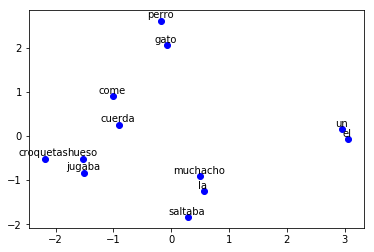

In [15]:
plot_words(C.T[:-2],label)

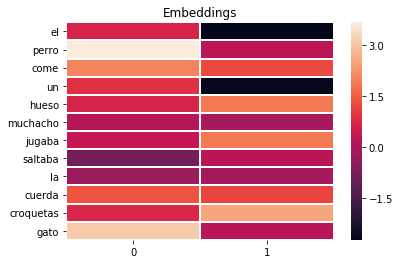

In [16]:
ax = sns.heatmap(C.T[:-2], linewidth=1.0, yticklabels=label[:-2])
ax.set_title('Embeddings')
plt.show()

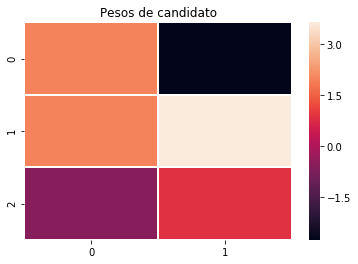

In [17]:
ax = sns.heatmap(Uc, linewidth=1.0) #, yticklabels=label)
ax.set_title('Pesos de candidato')
plt.show()

### Visualización de las puertas y los estados ocultos

In [18]:
def get_cells(sent, h0 = np.zeros(cell_dim),c0=np.zeros(cell_dim)):
    sent = sent.split()
    prob_tot = np.zeros((len(sent),N))
    
    #Longitud sente
    long = len(sent)
    #Matrices de puertas por estado
    i = np.zeros((long+1, cell_dim))
    o = np.zeros((long+1, cell_dim))
    f = np.zeros((long+1, cell_dim))
    c_hat = np.zeros((long+1, cell_dim))
    c = np.zeros((long+1, cell_dim))
    h = np.zeros((long+1, cell_dim))
    
    #Inicializar h y c
    c[0] = c0
    h[0] = h0
    
    for t,w in enumerate(sent):
        #Embedding
        x = C.T[voc[w]]
        #LSTM
        #Puerta de escritura
        i[t+1] = sig(np.dot(Vi,h[t]) + np.dot(Ui,x) + bi)
        #Puerta de olvido
        f[t+1] = sig(np.dot(Vf,h[t]) + np.dot(Uf,x) + bf)
        #Puerta de escritura
        o[t+1] = sig(np.dot(Vo,h[t]) + np.dot(Uo,x) + bo)

        #Candidato a sombra
        c_hat[t+1] = np.tanh(np.dot(Vc,h[t]) + np.dot(Uc,x) + bc)

        #Sombra en el estado actual
        c[t+1] = f[t+1]*c[t] + i[t+1]*c_hat[t+1]

        #Celda en el estado actual
        h[t+1] = o[t+1]*np.tanh(c[t+1])

        #FORWARD SALIDA
        #Softmax
        p = np.exp(np.dot(W,h[t+1])+b)
        phi = p/p.sum(0)
        
        #Se almacenan las probabilidades
        prob_tot[t] = phi
        
    return (i,o,f),h,c_hat,c, prob_tot 

In [19]:
ex = 'el perro come un gato'
gates, h,c_hat,c, p = get_cells(ex)

states = [0] + ex.split()

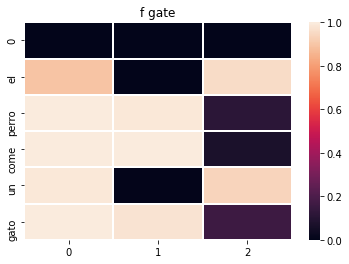

In [20]:
#Puerta de olvido
ax = sns.heatmap(gates[2], linewidth=1.0, yticklabels=states)
ax.set_title('f gate')
plt.show()

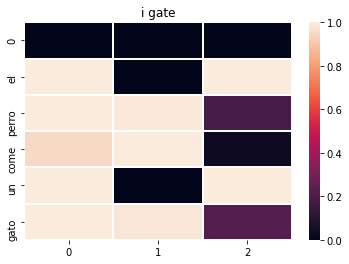

In [21]:
#Puerta de lectura i
ax = sns.heatmap(gates[0], linewidth=1.0, yticklabels=states)
ax.set_title('i gate')
plt.show()

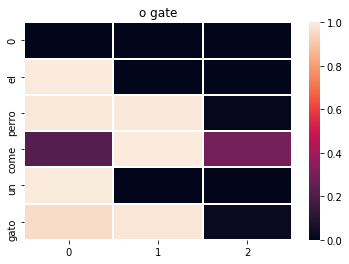

In [22]:
#Puerta de escritura
ax = sns.heatmap(gates[1], linewidth=1.0, yticklabels=states)
ax.set_title('o gate')
plt.show()

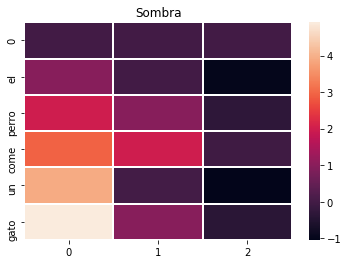

In [23]:
ax = sns.heatmap(c, linewidth=1.0, yticklabels=states)
ax.set_title('Sombra')
plt.show()

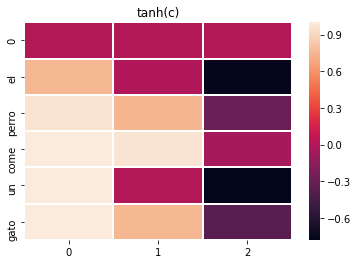

In [24]:
ax = sns.heatmap(np.tanh(c), linewidth=1.0, yticklabels=states)
ax.set_title('tanh(c)')
plt.show()

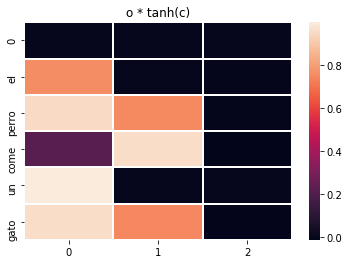

In [25]:
ax = sns.heatmap(gates[1]*np.tanh(c), linewidth=1.0, yticklabels=states)
ax.set_title('o * tanh(c)')
plt.show()

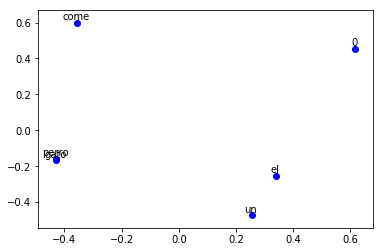

In [26]:
plot_words(h,states)

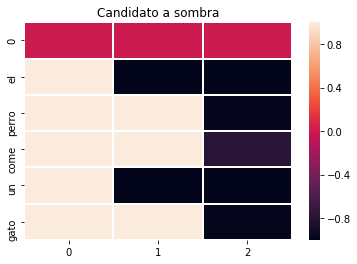

In [27]:
ax = sns.heatmap(c_hat, linewidth=1.0, yticklabels=states)
ax.set_title('Candidato a sombra')
plt.show()